## IMDB Movie Review Sentiment Analysis - LSTM
Sentiment analysis is one the most common applications of natural language processing in AI.  Sentiment analysis has become an extremely  important customer service tool these days. Here we will train a sentiment classifier of movie reviews from the IMDB data set using a Recurrent Neural Network (RNN).  We will use a Keras/TensorFlow LSTM implementation in our RNN layers.  The dataset includes 25,000 training and 25,000 test samples. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.metrics import confusion_matrix
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# set random seed
seed = 7
np.random.seed(seed)

In [3]:
# load the IMDB dataset
vocab = 50000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab)
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [4]:
# review basic dataset properies
print("The shape of X:", X.shape)
print("The shape of y:", y.shape)
print("Classes:", np.unique(y))

The shape of X: (50000,)
The shape of y: (50000,)
Classes: [0 1]


In [5]:
# review IMDB data elements
print("----Review----")
print(X[1])
print("----Label----")
print(y[1])
print("=========================================================")
print("----Review----")
print(X[35000])
print("----Label----")
print(y[35000])

----Review----
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 10156, 4, 1153, 9, 194, 775, 7, 8255, 11596, 349, 2637, 148, 605, 15358, 8003, 15, 123, 125, 68, 23141, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 36893, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 25249, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 46151, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]
----Label----
0
----Review----
[1, 670, 5304, 5622, 13500, 308, 8551, 23033, 25, 71, 1017, 6, 253, 22, 4, 436, 223, 100, 358,

In [6]:
# checkout IMDB word to word index mapping
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}
print('---review with words---')
print([id2word.get(i, ' ') for i in X_train[6]])
print('---label---')
print(y_train[6])

---review with words---
['the', 'boiled', 'full', 'involving', 'to', 'impressive', 'boring', 'this', 'as', 'murdering', 'naschy', 'br', 'villain', 'council', 'suggestion', 'need', 'has', 'of', 'costumes', 'b', 'message', 'to', 'may', 'of', 'props', 'this', 'echoed', 'concentrates', 'concept', 'issue', 'skeptical', 'to', "god's", 'he', 'is', 'and', 'unfolds', 'movie', 'women', 'like', "isn't", 'surely', "i'm", 'rocketed', 'to', 'toward', 'in', "here's", 'for', 'from', 'did', 'having', 'because', 'very', 'quality', 'it', 'is', "captain's", 'starship', 'really', 'book', 'is', 'both', 'too', 'worked', 'carl', 'of', 'and', 'br', 'of', 'reviewer', 'closer', 'figure', 'really', 'there', 'will', 'originals', 'things', 'is', 'far', 'this', 'make', 'mistakes', "kevin's", 'was', "couldn't", 'of', 'few', 'br', 'of', 'you', 'to', "don't", 'female', 'than', 'place', 'she', 'to', 'was', 'between', 'that', 'nothing', 'dose', 'movies', 'get', 'are', 'and', 'br', 'yes', 'female', 'just', 'its', 'because

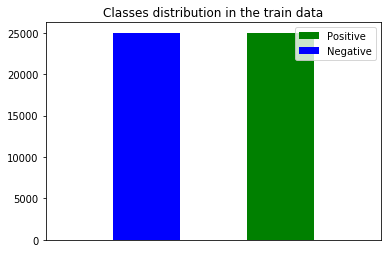

In [7]:
# check class balance
plt.hist([i for i in y if i == 1],
         bins=2, color='green', label='Positive')
plt.hist([j for j in y if j ==0],
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data')
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [8]:
# summarize the review data
nb_words = len(np.unique(np.hstack(X)))
print("Number of words:", nb_words)
result = [len(x) for x in X]
print("Review mean length %.2f, standard deviation (%f)" % (np.mean(result), np.std(result)))

Number of words: 49998
Review mean length 234.76, standard deviation (172.911495)


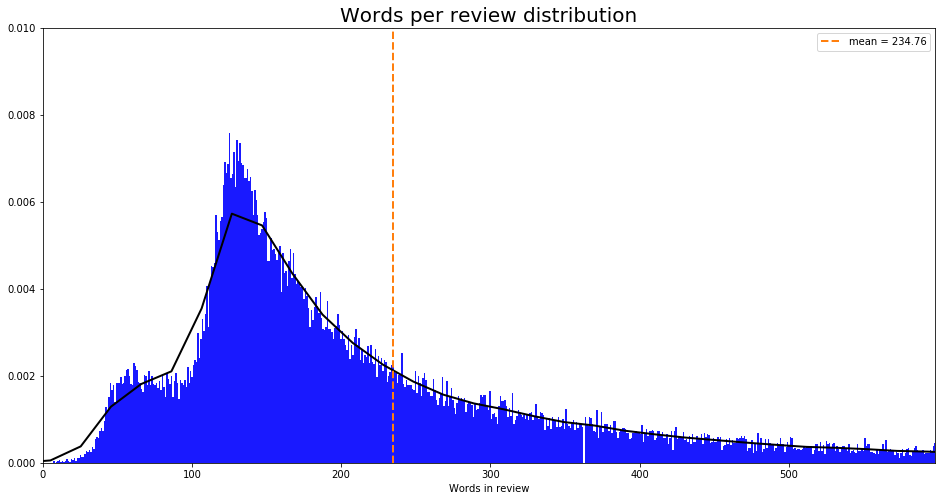

In [9]:
# plot review data
mean = np.mean(result)
num_bins = max(result)
fig, ax = plt.subplots(figsize=(16,8))
sb.distplot(result, bins=num_bins,
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 2})
ax.set_xlim(left=0, right=np.percentile(result, 95))
ax.set_xlabel('Words in review')
ymax = 0.010
plt.ylim(0, ymax)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

In [10]:
# set max review length and pad the shorter sequences
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [11]:
# define the LSTM model
def lstm_model(vocab, word_vector_dim, max_words):
    model = Sequential()
    model.add(Embedding(vocab, word_vector_dim, input_length=max_words))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.4))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [12]:
# create the model
word_vector_dim = 32
model = lstm_model(vocab, word_vector_dim, max_words)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           1600000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               164864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               64250     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 1,829,365
Trainable params: 1,829,365
Non-trainable params: 0
_________________________________________________________________


In [13]:
# fit the model
batch_size = 128
nb_epochs = 20
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size, validation_data=(X_test, y_test)).history

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 664s 27ms/step - loss: 0.5202 - acc: 0.7301 - val_loss: 0.5479 - val_acc: 0.7319
Epoch 2/20
25000/25000 [==============================] - 696s 28ms/step - loss: 0.2688 - acc: 0.8919 - val_loss: 0.3103 - val_acc: 0.8718
Epoch 3/20
25000/25000 [==============================] - 936s 37ms/step - loss: 0.1259 - acc: 0.9555 - val_loss: 0.3772 - val_acc: 0.8573
Epoch 4/20
25000/25000 [==============================] - 930s 37ms/step - loss: 0.0785 - acc: 0.9735 - val_loss: 0.5375 - val_acc: 0.8611
Epoch 5/20
25000/25000 [==============================] - 937s 37ms/step - loss: 0.0553 - acc: 0.9814 - val_loss: 0.5150 - val_acc: 0.8530
Epoch 6/20
25000/25000 [==============================] - 574s 23ms/step - loss: 0.0467 - acc: 0.9844 - val_loss: 0.5809 - val_acc: 0.8422
Epoch 7/20
25000/25000 [==============================] - 482s 19ms/step - loss: 0.0251 - acc: 0.9921 - val_loss: 0.

In [18]:
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

25000/25000 [==============================] - 95s 4ms/step
Accuracy: 83.93%


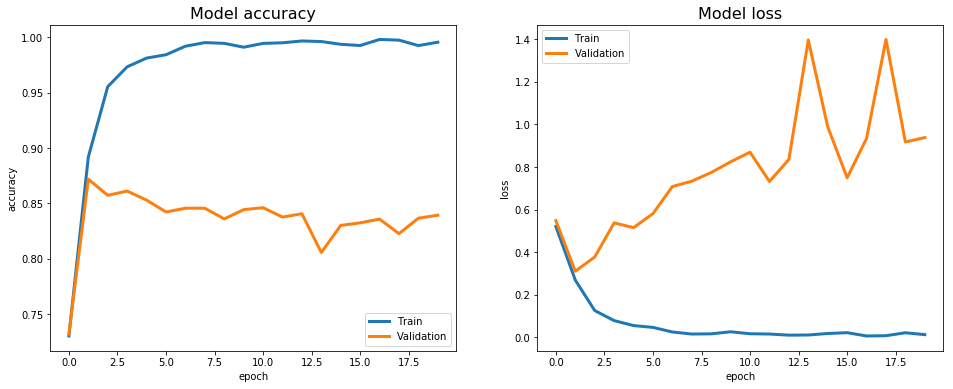

In [14]:
# plot the model loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history['acc'], label='Train', linewidth=3)
axis1.plot(history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# summarize history for loss
axis2.plot(history['loss'], label='Train', linewidth=3)
axis2.plot(history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper left')
plt.show()

In [15]:
# define the confusion matrix
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [16]:
# predict class outputs
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

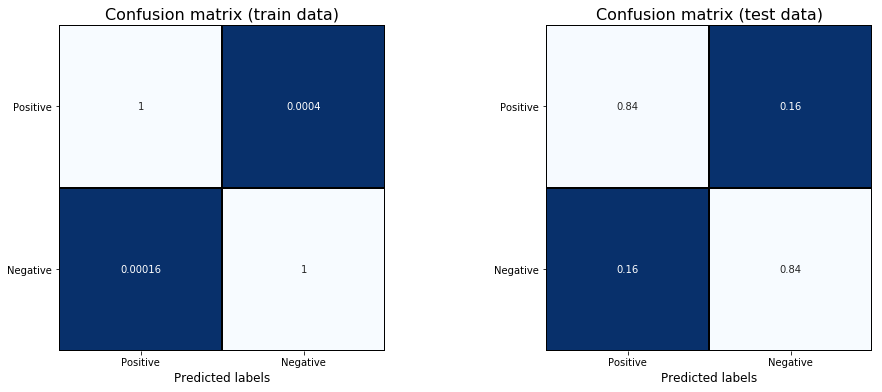

In [17]:
# plot the confusion matrix
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])
plt.show()